In [1]:
import pandas as pd

In [2]:
df_netflix=pd.read_csv("netflix_titles.csv/netflix_titles.csv")

df_netflix['title_new']=df_netflix['title'].str.lower().str.strip()
df_netflix['release_year']=df_netflix['release_year'].astype(str)

In [3]:
df_netflix

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,title_new
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,norm of the north: king sized adventure
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,jandino: whatever it takes
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",transformers prime
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,transformers: robots in disguise
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,#realityhigh
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil...",red vs. blue
6230,70286564,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews...",maron
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...,little baby bum: nursery rhyme friends
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ...",a young doctor's notebook and other stories


In [4]:
df_imdb_basics=pd.read_csv("title.basics.tsv.gz",sep='\t',dtype=str,na_values='\\N')

In [5]:
df_imdb_basics=df_imdb_basics[df_imdb_basics['titleType'].isin(['movie','short','tvseries'])]

df_imdb_basics['primaryTitle_new']=df_imdb_basics['primaryTitle'].str.lower().str.strip()
df_imdb_basics['startYear']=df_imdb_basics['startYear'].astype(str)

In [6]:
df_merge_exact = pd.merge(
    df_netflix,
    df_imdb_basics[['tconst', 'primaryTitle_new', 'startYear']],
    left_on=['title_new', 'release_year'],
    right_on=['primaryTitle_new', 'startYear'],
    how='left'
)


In [7]:
imdb_title_to_tconst = dict(zip(
    df_imdb_basics['primaryTitle_new'], df_imdb_basics['tconst']
))

In [8]:
df_unmatched = df_merge_exact[df_merge_exact['tconst'].isnull()].copy()

In [9]:
from rapidfuzz import process

from tqdm.auto import tqdm
tqdm.pandas() 

def fuzzy_match_title(title):
    match, score, _ = process.extractOne(title, imdb_title_to_tconst.keys())
    return imdb_title_to_tconst[match] if score >= 90 else None

df_unmatched['tconst'] = df_unmatched['title_new'].progress_apply(fuzzy_match_title)

d:\Netflix_Content_Strategy\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3061/3061 [1:40:31<00:00,  1.97s/it]  


In [10]:
df_matched = df_merge_exact[df_merge_exact['tconst'].notnull()]
df_final = pd.concat([df_matched, df_unmatched], ignore_index=True)

In [11]:
df_ratings = pd.read_csv("title.ratings.tsv.gz", sep="\t", dtype=str, na_values="\\N")
df_final = pd.merge(df_final, df_ratings, on="tconst", how="left")

In [12]:
df_final=df_final.drop(['primaryTitle_new','title_new','startYear','description','show_id'],axis=1)
df_final

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,tconst,averageRating,numVotes
0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",tt9428190,3.4,578
1,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,tt6119504,5.1,7143
2,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers",tt1971325,6.0,60800
3,Movie,Good People,Henrik Ruben Genz,"James Franco, Kate Hudson, Tom Wilkinson, Omar...","United States, United Kingdom, Denmark, Sweden","September 8, 2017",2014,R,90 min,"Action & Adventure, Thrillers",tt1361318,5.5,17701
4,Movie,Kidnapping Mr. Heineken,Daniel Alfredson,"Jim Sturgess, Sam Worthington, Ryan Kwanten, A...","Netherlands, Belgium, United Kingdom, United S...","September 8, 2017",2015,R,95 min,"Action & Adventure, Dramas, International Movies",tt2917388,6.1,22174
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,TV Show,Kikoriki,NaN,Igor Dmitriev,NaN,NaN,2010,TV-Y,2 Seasons,Kids' TV,tt0206078,4.8,15
7184,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...",tt33013156,NaN,NaN
7185,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,tt0066034,5.2,372
7186,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,tt9886688,NaN,NaN


In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7188 entries, 0 to 7187
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   type           7188 non-null   object
 1   title          7188 non-null   object
 2   director       5006 non-null   object
 3   cast           6569 non-null   object
 4   country        6657 non-null   object
 5   date_added     7177 non-null   object
 6   release_year   7188 non-null   object
 7   rating         7178 non-null   object
 8   duration       7188 non-null   object
 9   listed_in      7188 non-null   object
 10  tconst         7175 non-null   object
 11  averageRating  4249 non-null   object
 12  numVotes       4249 non-null   object
dtypes: object(13)
memory usage: 730.2+ KB


In [14]:
df_final['rating'].unique()

array(['TV-PG', 'TV-14', 'R', 'NR', 'TV-MA', 'PG-13', 'TV-G', 'PG', 'G',
       'UR', 'TV-Y7-FV', 'TV-Y', 'TV-Y7', nan, 'NC-17'], dtype=object)

In [15]:
df=df_final.drop(['rating','tconst'],axis=1)
df

,type,title,director,cast,country,date_added,release_year,duration,listed_in,averageRating,numVotes
0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,90 min,"Children & Family Movies, Comedies",3.4,578
1,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,99 min,Comedies,5.1,7143
2,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers",6.0,60800
3,Movie,Good People,Henrik Ruben Genz,"James Franco, Kate Hudson, Tom Wilkinson, Omar...","United States, United Kingdom, Denmark, Sweden","September 8, 2017",2014,90 min,"Action & Adventure, Thrillers",5.5,17701
4,Movie,Kidnapping Mr. Heineken,Daniel Alfredson,"Jim Sturgess, Sam Worthington, Ryan Kwanten, A...","Netherlands, Belgium, United Kingdom, United S...","September 8, 2017",2015,95 min,"Action & Adventure, Dramas, International Movies",6.1,22174
...,...,...,...,...,...,...,...,...,...,...,...
7183,TV Show,Kikoriki,NaN,Igor Dmitriev,NaN,NaN,2010,2 Seasons,Kids' TV,4.8,15
7184,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...",NaN,NaN
7185,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,4 Seasons,TV Comedies,5.2,372
7186,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,60 min,Movies,NaN,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7188 entries, 0 to 7187
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   type           7188 non-null   object
 1   title          7188 non-null   object
 2   director       5006 non-null   object
 3   cast           6569 non-null   object
 4   country        6657 non-null   object
 5   date_added     7177 non-null   object
 6   release_year   7188 non-null   object
 7   duration       7188 non-null   object
 8   listed_in      7188 non-null   object
 9   averageRating  4249 non-null   object
 10  numVotes       4249 non-null   object
dtypes: object(11)
memory usage: 617.8+ KB


In [17]:
df

,type,title,director,cast,country,date_added,release_year,duration,listed_in,averageRating,numVotes
0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,90 min,"Children & Family Movies, Comedies",3.4,578
1,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,99 min,Comedies,5.1,7143
2,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers",6.0,60800
3,Movie,Good People,Henrik Ruben Genz,"James Franco, Kate Hudson, Tom Wilkinson, Omar...","United States, United Kingdom, Denmark, Sweden","September 8, 2017",2014,90 min,"Action & Adventure, Thrillers",5.5,17701
4,Movie,Kidnapping Mr. Heineken,Daniel Alfredson,"Jim Sturgess, Sam Worthington, Ryan Kwanten, A...","Netherlands, Belgium, United Kingdom, United S...","September 8, 2017",2015,95 min,"Action & Adventure, Dramas, International Movies",6.1,22174
...,...,...,...,...,...,...,...,...,...,...,...
7183,TV Show,Kikoriki,NaN,Igor Dmitriev,NaN,NaN,2010,2 Seasons,Kids' TV,4.8,15
7184,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...",NaN,NaN
7185,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,4 Seasons,TV Comedies,5.2,372
7186,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,60 min,Movies,NaN,NaN


In [18]:
df['release_year']=pd.to_numeric(df["release_year"],errors='coerce')
df['averageRating']=pd.to_numeric(df["averageRating"],errors='coerce')
df['numVotes']=pd.to_numeric(df["numVotes"],errors='coerce')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7188 entries, 0 to 7187
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type           7188 non-null   object 
 1   title          7188 non-null   object 
 2   director       5006 non-null   object 
 3   cast           6569 non-null   object 
 4   country        6657 non-null   object 
 5   date_added     7177 non-null   object 
 6   release_year   7188 non-null   int64  
 7   duration       7188 non-null   object 
 8   listed_in      7188 non-null   object 
 9   averageRating  4249 non-null   float64
 10  numVotes       4249 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 617.8+ KB


In [20]:
df["director"]=df["director"].fillna(df["director"].mode()[0])

In [21]:
df["cast"]=df["cast"].fillna(df["cast"].mode()[0])
df["country"]=df["country"].fillna(df["country"].mode()[0])
df["date_added"]=df["date_added"].fillna(df["date_added"].mode()[0])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7188 entries, 0 to 7187
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type           7188 non-null   object 
 1   title          7188 non-null   object 
 2   director       7188 non-null   object 
 3   cast           7188 non-null   object 
 4   country        7188 non-null   object 
 5   date_added     7188 non-null   object 
 6   release_year   7188 non-null   int64  
 7   duration       7188 non-null   object 
 8   listed_in      7188 non-null   object 
 9   averageRating  4249 non-null   float64
 10  numVotes       4249 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 617.8+ KB


In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='averageRating', ylabel='Count'>

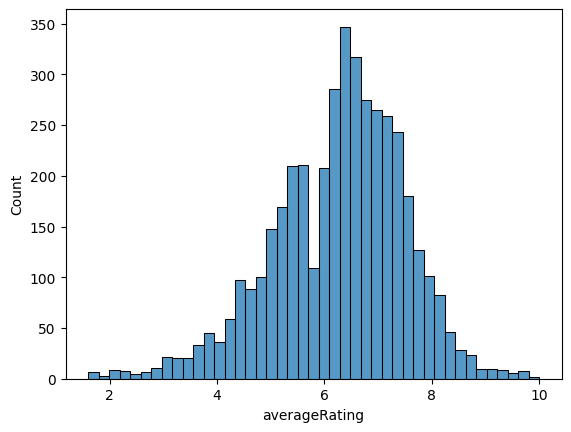

In [24]:
sns.histplot(df["averageRating"])

In [25]:
df["averageRating"]=df["averageRating"].fillna(df["averageRating"].median())

<Axes: xlabel='numVotes', ylabel='Count'>

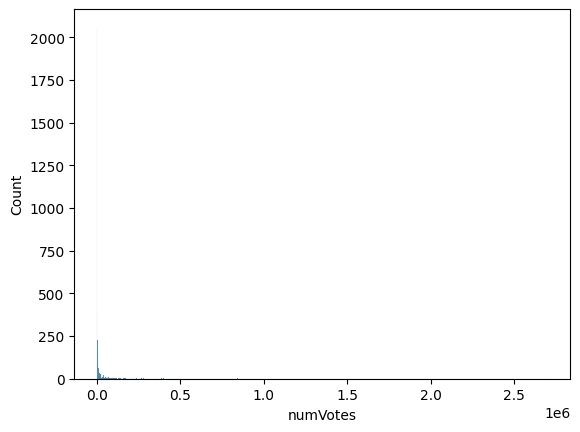

In [26]:
sns.histplot(df["numVotes"])

In [27]:
df["numVotes"]=df["numVotes"].fillna(df["numVotes"].median())

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7188 entries, 0 to 7187
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type           7188 non-null   object 
 1   title          7188 non-null   object 
 2   director       7188 non-null   object 
 3   cast           7188 non-null   object 
 4   country        7188 non-null   object 
 5   date_added     7188 non-null   object 
 6   release_year   7188 non-null   int64  
 7   duration       7188 non-null   object 
 8   listed_in      7188 non-null   object 
 9   averageRating  7188 non-null   float64
 10  numVotes       7188 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 617.8+ KB


In [29]:
df.to_csv("cleaned_data.csv",index=False)